In [1]:
!pip install python-dotenv langchain_openai langchain 'crewai[tools]' -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.9/45.9 kB 825.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 975.5/975.5 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.4/337.4 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.3/328.3 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.5/127.5 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.5/203.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

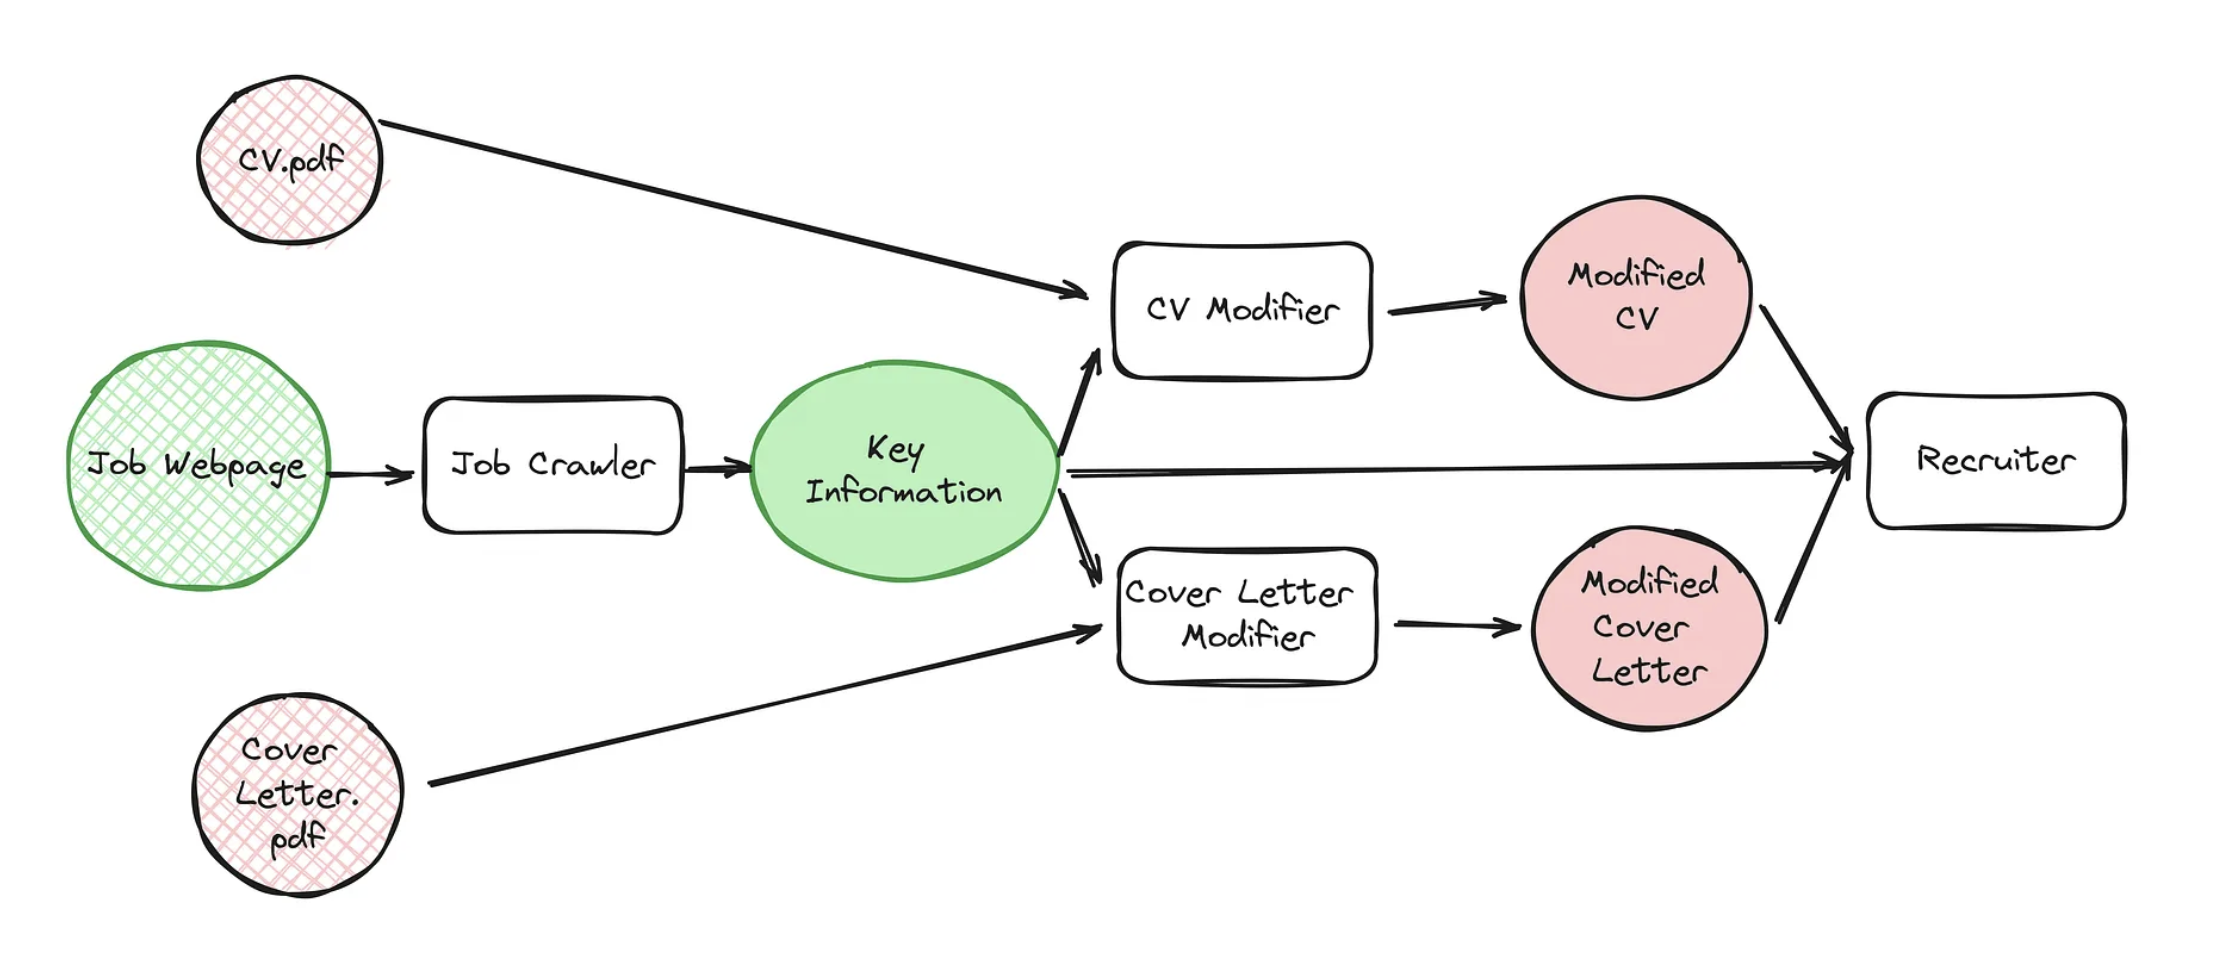

In [2]:
from dotenv import load_dotenv
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from langchain.tools import tool
import re

# Load your OPENAI_API_KEY from your .env file
load_dotenv()

# The model for the agents
model = ChatOpenAI(model_name="gpt-4-turbo", temperature=0.8,api_key="")

In [3]:
!pip install langchain_community -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 4.6 MB/s eta 0:00:00


In [4]:
from langchain_community.document_loaders import PyMuPDFLoader
import requests

# Tool for loading and reading a PDF locally
@tool
def fetch_pdf_content(pdf_path: str):
    """
    Reads a local PDF and returns the content
    """
    loader = PyMuPDFLoader(pdf_path)
    data = loader.load()[0]
    return data.page_content

# Tool for loading a webpage
@tool
def get_webpage_contents(url: str):
    """
    Reads the webpage with a given URL and returns the page content
    """
    try:
        response = requests.get(url)
        response.raise_for_status()  # Check for HTTP errors
        return response.text
    except requests.exceptions.RequestException as e:
        return str(e)

Having my model and the needed tools ready, next is to define my agents. Agents in CrewAI need three main attributes, the role, the goal, and the backstory. For each agent, we will specify a set of needed tools. Agents also have the option to delegate part of their tasks to other agents, but since this project is not that complex, we set allow_delegation to False for all of our agents.

In [5]:
job_crawler = Agent(
    role='Job Description Crawler',
    goal='Extract the relevant job description, requirements and qualificiations',
    backstory='Specialized in parsing HTML and retrieving important information from it',
    verbose=True,
    tools=[get_webpage_contents],
    allow_delegation=False,
    llm=model
)

cv_modifier = Agent(
    role='CV/Resume Writer',
    goal='Write a top-notch CV that increases the chance of landing an interview',
    backstory='Expert in writing CV that is best recieved by the recruiting team and HR',
    verbose=True,
    tools=[fetch_pdf_content],
    allow_delegation=False,
    llm=model
)

cover_letter_modifier = Agent(
    role='Cover Letter Writer',
    goal='Write an intriguing cover letter that boosts the chance of landing an interview',
    backstory='Expert in writing Cover Letter that is best recieved by the recruiting team and HR',
    verbose=True,
    tools=[fetch_pdf_content],
    allow_delegation=False,
    llm=model
)

recruiter = Agent(
    role='Hiring Manager',
    goal='Analyze how well a candidate is suited for a job description, given their CV and Cover Letter',
    backstory='Experienced hiring manager with an especialization of giving feedback to job seekers',
    verbose=True,
    allow_delegation=False,
    llm=model
)

Now we need to list our tasks. A task is a specific job you want a particular agent to do. I will assign one task to each agent. I will explain the description of my task, along with specifically how I want the output of the task to be.

In [6]:
def extract_job_information(page_url):
    return Task(
        description=f"Given this url: {page_url}, extract the job description, and relative information about the job",
        agent=job_crawler,
        expected_output="Key points of the job description, requirements, and qualifications needed for the job",
    )

def cv_modifying(cv_path):
    return Task(
        description=f"Read the CV at this local path: {cv_path}, then\
        modify the keypoints and the order of the skills, to make it emphasize what is needded by the job.\
        Do NOT add any extra skill or new information, keep it honest.",
        agent=cv_modifier,
        expected_output="A modified version of CV, tailor-made for the job description",
    )

def cover_letter_modifying(cv_path):
    return Task(
        description=f"Read the cover letter at this local path: {cv_path},\
        then baseed on the provided job description by 'job_crawler' agent, \
        modify it to make it target the provided job description. Fill in the empty brackets with the company name.\
        Do NOT add any extra skill or new information, keep it honest.",
        agent=cover_letter_modifier,
        expected_output="A modified version of cover letter, tailor-made for the job description",
    )

evaluate = Task(
        description=f"Provided the modified CV and Cover Letter, and the key points of the job description,\
        give a score to the candidate from 0-100, based on how well suited they are for this job",
        agent=recruiter,
        expected_output="Score in the range [0-100]",
    )

In [9]:
# USER INPUTS
cover_letter_path = '/content/Ankush_Singal_Data Scientist_IT_10+_CL.pdf'
cv_path = '/content/Ankush_Singal_CV (1).pdf'
job_url = ["www.monster.com"]

extract_job_information_task = extract_job_information(job_url)
cv_modifying_task = cv_modifying(cv_path)
cover_letter_modifying_task = cover_letter_modifying(cover_letter_path)

# make the crew
crew = Crew(
    agents=[job_crawler, cv_modifier, cover_letter_modifier, recruiter],
    tasks=[
    extract_job_information_task,
    cv_modifying_task,
    cover_letter_modifying_task,
    evaluate
    ],
    verbose=2
)

# Let's start!
result = crew.kickoff()

 [2024-07-04 08:42:55][DEBUG]: == Working Agent: Job Description Crawler
 [2024-07-04 08:42:55][INFO]: == Starting Task: Given this url: ['www.monster.com'], extract the job description, and relative information about the job


> Entering new CrewAgentExecutor chain...
Thought: First, I need to retrieve the content from the specified URL to analyze and extract the necessary job-related information.

Action: get_webpage_contents
Action Input: {"url": "www.monster.com"} 

Invalid URL 'www.monster.com': No scheme supplied. Perhaps you meant https://www.monster.com?

Thought: It seems the URL provided is missing the scheme. I need to correct the format of the URL by adding "https://" and attempt to retrieve the content again.

Action: get_webpage_contents
Action Input: {"url": "https://www.monster.com"} 

<!DOCTYPE html><html lang="en-us"><head><meta charSet="utf-8"/><meta http-equiv="x-ua-compatible" content="ie=edge"/><meta name="viewport" content="width=device-width, initial-scale=1, sh